In [1]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys
from glob import glob 
import vaex
from tqdm import tqdm
from hammer import vel
from scipy.stats import median_abs_deviation as mad_func
root_dir = abspath(join('..', '..'))
root_data_dir = join(root_dir, 'Data')
sys.path.append(root_dir)
from utils import (plot_corner, plot_chain, plot_fit_w, style, get_params,
                   get_initial_position_normal, get_data, generate_init)

In [2]:
style()

In [3]:
zpath = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'z')
wpath = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'z')
zpath, wpath

('/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z')

In [4]:
name = "Baryon"
baryon_dir = join(root_data_dir, name)
baryon_dir

'/home2/s20321005/Thesis-Project/Data/Baryon'

In [5]:
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [6]:
ind = 0
zdata, wdata = get_data(zpath, wpath, ind)
files = glob(join(zpath, "z*"))
files.sort()
name_pred = files[ind].split("/")[-1].split(".")[0].replace("z", "pred") + ".npy"
name_phi = files[ind].split("/")[-1].split(".")[0].replace("z", "phi") + ".npy"
name_pred, name_phi

('pred_178.npy', 'phi_178.npy')

In [7]:
# # Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101
# rhob = df_baryon["rho"].to_numpy()  # Msun/pc^3
# sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
# rhoDM = 0.02
# log_nu0 = 0
# R = 3.4E-3
# zsun = 30

# theta = concat(rhob, sigmaz, rhoDM, log_nu0, R, zsun)

# w0 = -7.
# sigma1 = 10.
# sigma2 = 15.
# log_sigmaw = np.log(sigma1)
# q_sigmaw = sigma1/sigma2
# a1 = 0.9
# a2 = 0.1
# log_a = np.log(a1)
# q_a = a2/a1
# psi = concat(w0, log_sigmaw, q_sigmaw, log_a, q_a)
# theta.shape, psi.shape

# Fit w

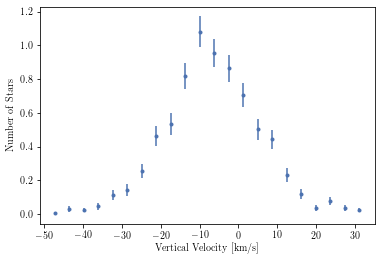

In [8]:
wmid, wnum, werr = wdata

plt.errorbar(wmid, wnum, yerr=werr, fmt='.')
plt.xlabel("Vertical Velocity [km/s]")
plt.ylabel("Number of Stars")
plt.show()

In [9]:
psi, locs, scales, labels, labs = generate_init("kin")
[(lb, l, l+s) for lb,  l,s in zip(labels, locs, scales)]

[('$w_0$', -15.0, 0.0),
 ('$\\log \\sigma_w$', 0.0, 5.0),
 ('$q_{\\sigma,w}$', 0.0, 1.0),
 ('$\\log a$', -1.0, 1.0),
 ('$q_a$', 0.0, 1.0),
 ('$\\log \\Phi$', 0.0, 10.0)]

In [10]:
ndim = len(labs)
nwalker = 10*ndim
p0 = vel.generate_p0(nwalker, locs, scales)
indexes = list(range(ndim))
p0.shape

(60, 6)

In [11]:
indexes = list(range(ndim))

for _ in tqdm(range(5)):
    chain = vel.mcmc(5000, p0, wdata, locs, scales, parallel=True, verbose=True)
    labs, locs_normal, scales_normal = get_initial_position_normal(labs, "kin", chain=chain[1000:], indexes=indexes)
    p0 = vel.generate_p0(nwalker, locs_normal, scales_normal, norm=True)
    chain = vel.mcmc(5000, p0, wdata, locs, scales, parallel=True, verbose=True)
    p0 = chain[-1]

100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


In [14]:
chain = vel.mcmc(100_000, p0, wdata, locs, scales, parallel=True, verbose=True)
chain_thin = chain[::100]

6it [00:00, 47.75it/s]


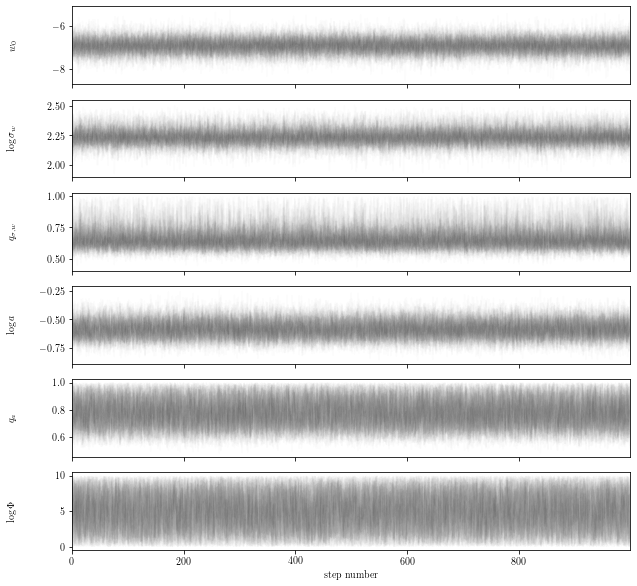

In [15]:
params = get_params(chain_thin, indexes, labs)

plot_chain(params, labels, alpha=0.01)

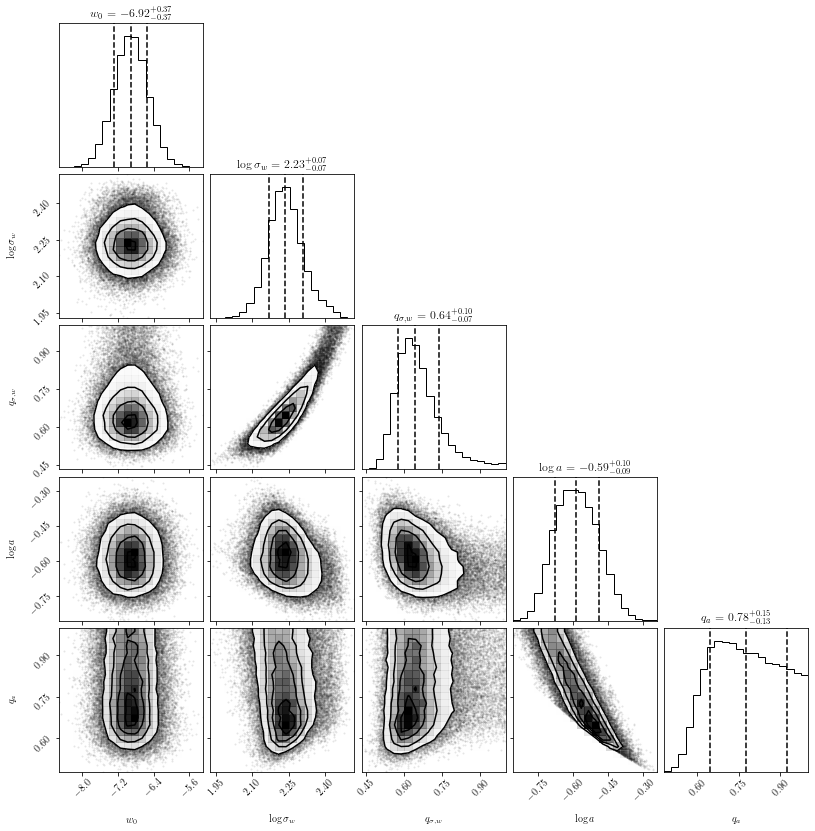

In [16]:
flat_samples = chain_thin.reshape(-1, ndim)
plot_corner(flat_samples[:, :-1], labels[:-1])

100%|██████████| 5000/5000 [00:00<00:00, 34819.64it/s]


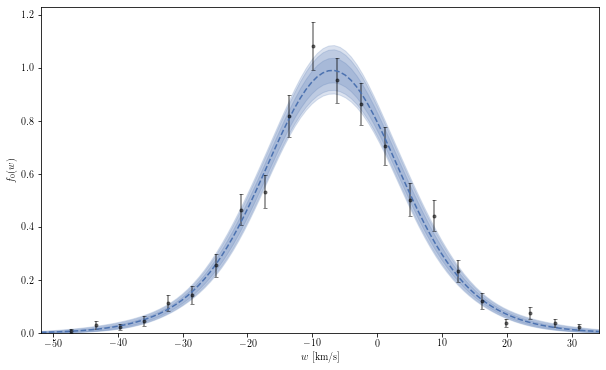

In [17]:
flat_samples = chain_thin.reshape(-1, ndim)

plot_fit_w(wdata, flat_samples, n=5000, alpha=0.2, c="C0",path=None, dpi=100)

## potential space

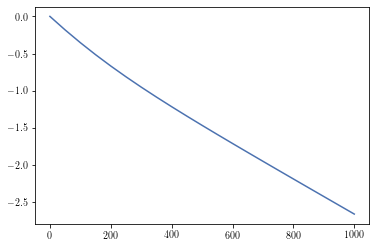

In [18]:
phi_max = 1000
phis = np.linspace(0.0001, phi_max, 21)
inds = np.random.randint(0, len(flat_samples), 5000)
log_sigmaw = flat_samples[inds[0], 1]
q_sigmaw = flat_samples[inds[0], 2]
log_a = flat_samples[inds[0], 3]
q_a = flat_samples[inds[0], 4]

sigmaw1 = np.exp(log_sigmaw)
sigmaw2 = sigmaw1 / q_sigmaw
a1 = np.exp(log_a)
a2 = a1 * q_a
atot = a1 + a2

nus = (a1*np.exp(-phis/sigmaw1**2) + a2*np.exp(-phis/sigmaw2**2))/atot

plt.plot(phis, np.log10(nus))
plt.show()

In [19]:
phis = np.linspace(0.0001, phi_max, 1000)
N = len(flat_samples)
print(N)
log_zmod_phi = np.empty((N, len(phis)))
for i in tqdm(range(N)):
    th = flat_samples[i]
    log_sigmaw = th[1]
    q_sigmaw = th[2]
    log_a = th[3]
    q_a = th[4]
    sigmaw1 = np.exp(log_sigmaw)
    sigmaw2 = sigmaw1 / q_sigmaw
    a1 = np.exp(log_a)
    a2 = a1 * q_a
    atot = a1 + a2
    zmod_phi_i = (a1*np.exp(-phis/sigmaw1**2)+a2*np.exp(-phis/sigmaw2**2))/atot
    log_zmod_phi[i] = np.log(zmod_phi_i)
log_zmod_phi

60000


100%|██████████| 60000/60000 [00:04<00:00, 12836.71it/s]


array([[-8.18050013e-07, -8.18382943e-03, -1.63554789e-02, ...,
        -4.98997456e+00, -4.99408290e+00, -4.99819116e+00],
       [-9.12047425e-07, -9.12298832e-03, -1.82300044e-02, ...,
        -5.59422693e+00, -5.59903112e+00, -5.60383527e+00],
       [-8.10221816e-07, -8.10918464e-03, -1.62136524e-02, ...,
        -6.73231418e+00, -6.73841946e+00, -6.74452443e+00],
       ...,
       [-8.50968543e-07, -8.51387986e-03, -1.70165573e-02, ...,
        -5.72399900e+00, -5.72894481e+00, -5.73389055e+00],
       [-9.51599961e-07, -9.51287552e-03, -1.89975887e-02, ...,
        -4.67626467e+00, -4.68018502e+00, -4.68410536e+00],
       [-9.03741048e-07, -9.03805356e-03, -1.80565880e-02, ...,
        -5.24771748e+00, -5.25223794e+00, -5.25675838e+00]])

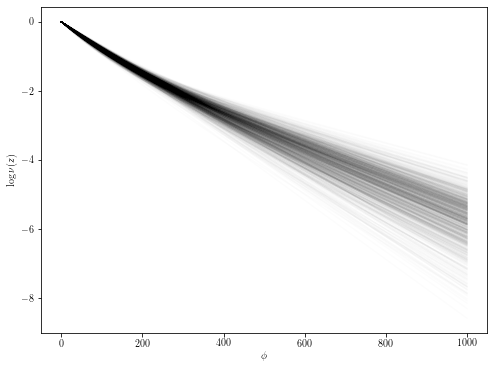

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(phis, log_zmod_phi[::60].T, 'k', alpha=0.01)
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\log \nu(z)$')
plt.show()

<BarContainer object of 34 artists>

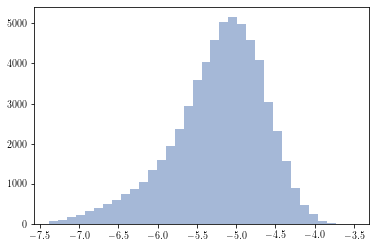

In [22]:
phi_i = 900
index = np.argmin(np.abs(phis-phi_i))
log_zmod_phi_i = log_zmod_phi[:, index]
med = np.median(log_zmod_phi_i)
mad = mad_func(log_zmod_phi_i)
mask = np.abs(log_zmod_phi_i-med) < 6*mad
log_zmod_phi_i = log_zmod_phi_i[mask]

low = med-6*mad
high = med+6*mad
yedge = np.linspace(low, high, 40)
dy = yedge[1]-yedge[0]
ymid = (yedge[1:]+yedge[:-1])/2
ynum, _ = np.histogram(log_zmod_phi_i, bins=yedge)
# ynum
mask = ynum > 0
ynum = ynum[mask]
ymid = ymid[mask]

# plot
plt.bar(ymid, ynum, width=dy, alpha=0.5)    

In [23]:
med = np.median(log_zmod_phi, axis=0)
mad = mad_func(log_zmod_phi, axis=0)
partition = 50
pred = np.empty((len(phis), 2, partition))
for i, (log_zmod_phi_i, med_i, mad_i) in enumerate(zip(log_zmod_phi.T, med, tqdm(mad))):
    mask = np.abs(log_zmod_phi_i-med_i) < 3*mad_i
    log_zmod_phi_i = log_zmod_phi_i[mask]
    low = med_i-3*mad_i
    high = med_i+3*mad_i
    log_znum_edge = np.linspace(low, high, partition+1)
    dy = log_znum_edge[1]-log_znum_edge[0]
    log_znum_mod = (log_znum_edge[1:]+log_znum_edge[:-1])/2
    znum_weight, _ = np.histogram(log_zmod_phi_i, bins=log_znum_edge)
    total = znum_weight.sum()
    znum_weight = znum_weight/total
    pred_i = np.array([np.exp(log_znum_mod), znum_weight])
    pred[i] = pred_i

100%|█████████▉| 999/1000 [00:04<00:00, 218.05it/s]


In [24]:
np.save(join(zpath, 'PHI', name_pred), pred)
np.save(join(zpath, 'PHI', name_phi), phis)

# Automate

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys
from glob import glob 
import vaex
from tqdm import tqdm
from hammer import vel
from scipy.stats import median_abs_deviation as mad_func
root_dir = abspath(join('..', '..'))
root_data_dir = join(root_dir, 'Data')
sys.path.append(root_dir)
from utils import (plot_corner, plot_chain, plot_fit_w, style, get_params,
                   get_initial_position_normal, get_data, generate_init)

In [2]:
style()

In [3]:
zpath = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'z')
wpath = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'z')
zpath, wpath

('/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z')

In [4]:
name = "Baryon"
baryon_dir = join(root_data_dir, name)
baryon_dir

'/home2/s20321005/Thesis-Project/Data/Baryon'

In [5]:
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


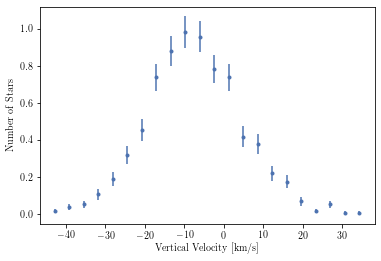

Running MCMC


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Running long mcmc


6it [00:00, 48.04it/s]
100%|██████████| 5000/5000 [00:00<00:00, 41760.21it/s]


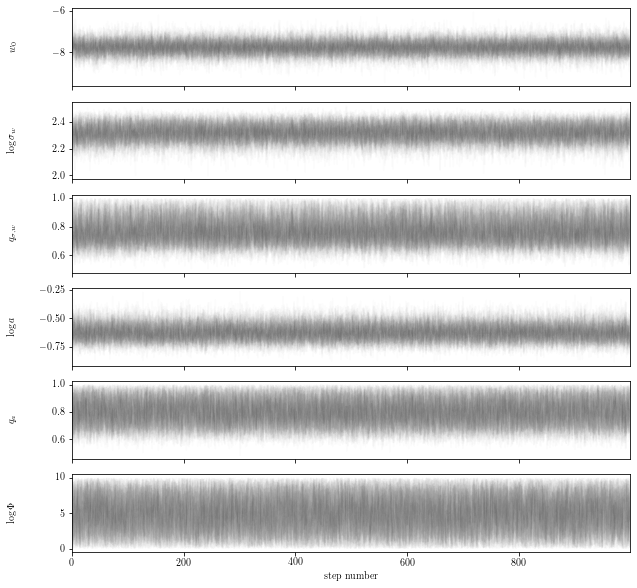

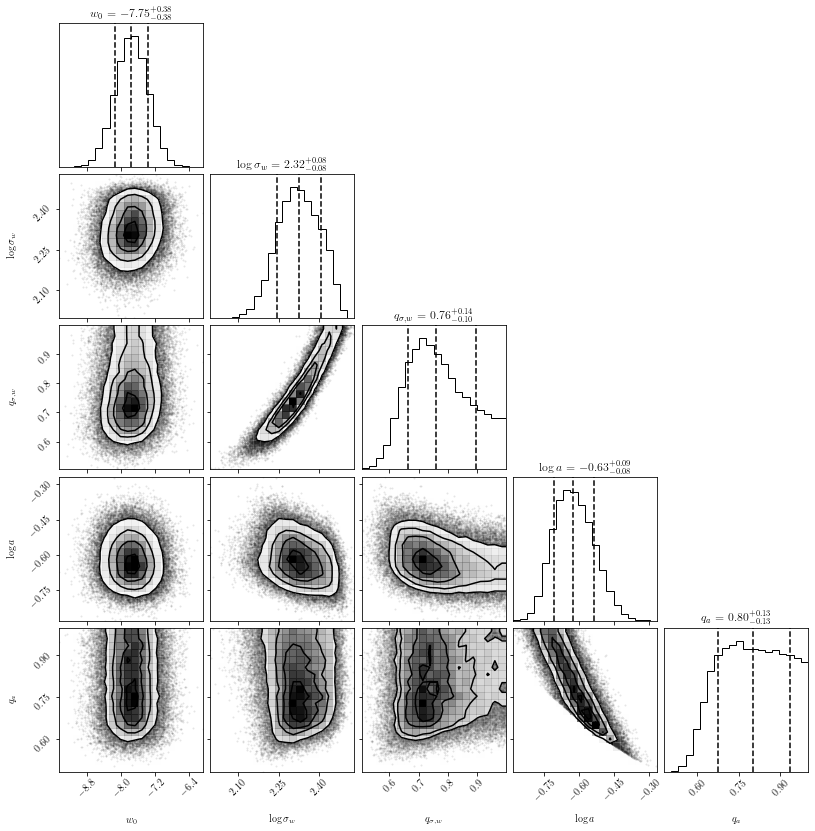

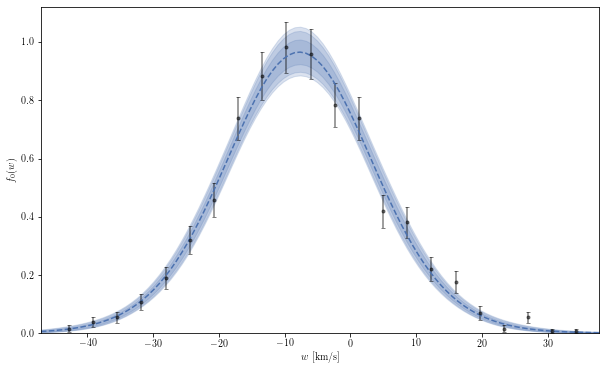

phi_max =  329.31885025908105
60000


100%|██████████| 60000/60000 [00:04<00:00, 12288.11it/s]


med and mad...
calculate pred...


100%|█████████▉| 999/1000 [00:04<00:00, 205.76it/s]


saving...
done pred_230.npy





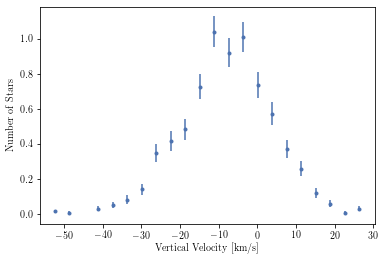

Running MCMC


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Running long mcmc


6it [00:00, 46.36it/s]
100%|██████████| 5000/5000 [00:00<00:00, 43185.49it/s]


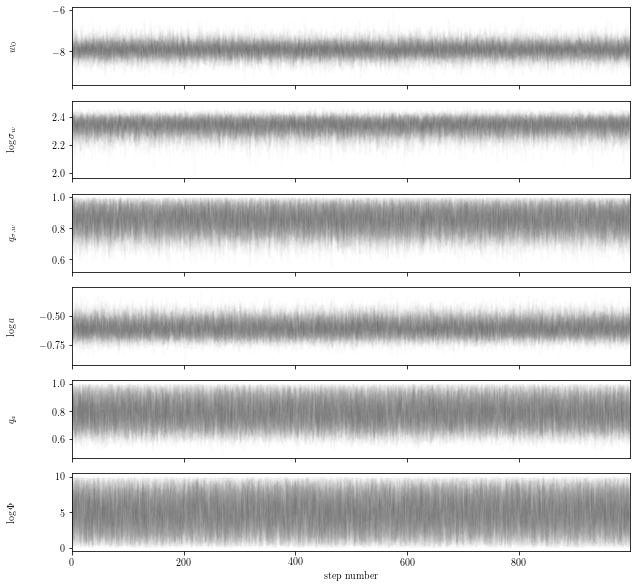

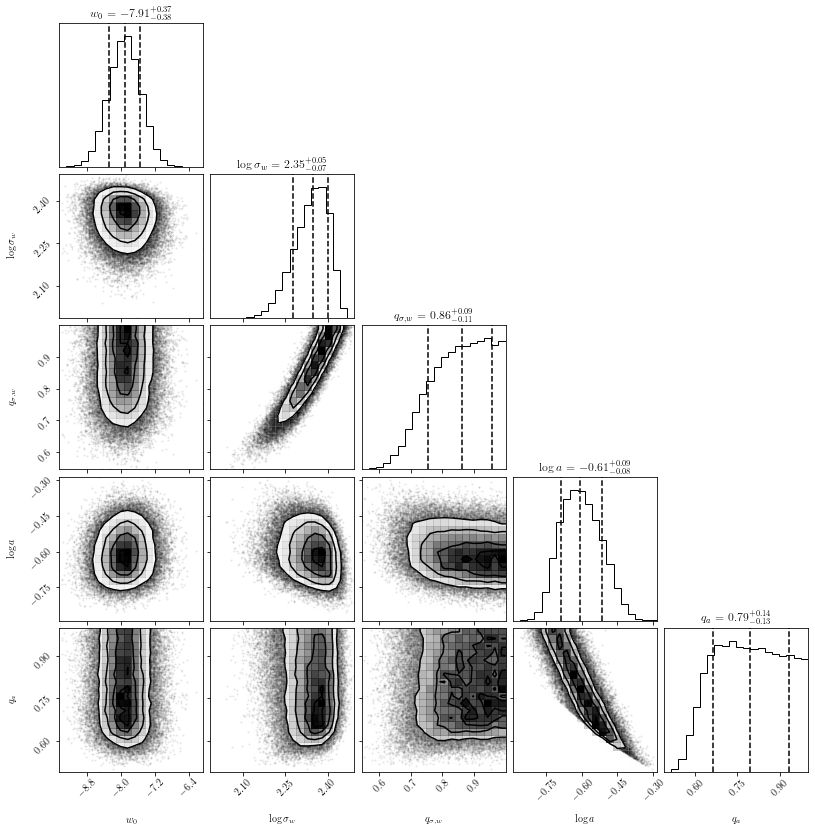

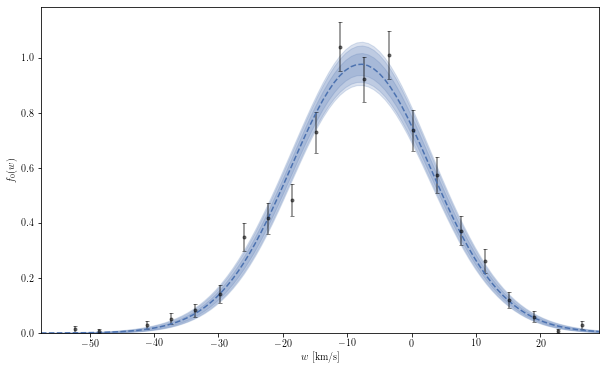

phi_max =  449.2911920010371
60000


100%|██████████| 60000/60000 [00:04<00:00, 12639.51it/s]


med and mad...
calculate pred...


100%|█████████▉| 999/1000 [00:04<00:00, 205.02it/s]


saving...
done pred_314.npy





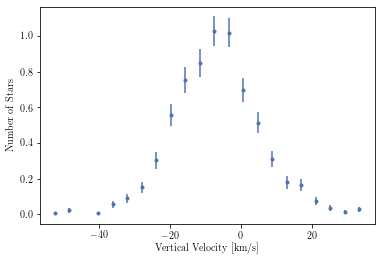

Running MCMC


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Running long mcmc


6it [00:00, 46.48it/s]
100%|██████████| 5000/5000 [00:00<00:00, 41838.19it/s]


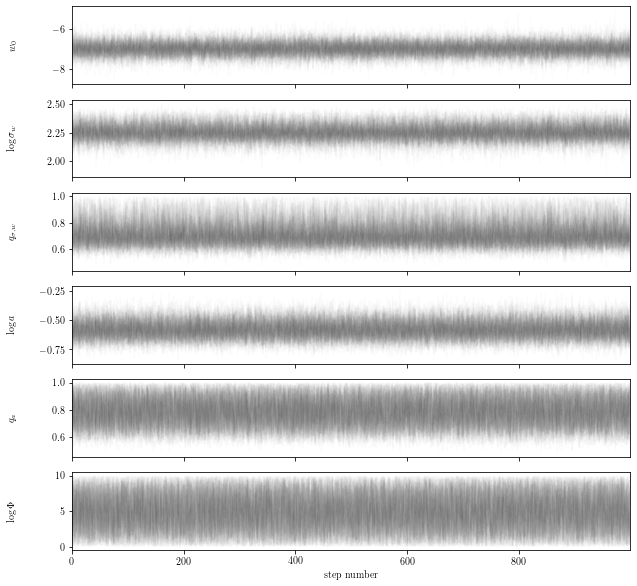

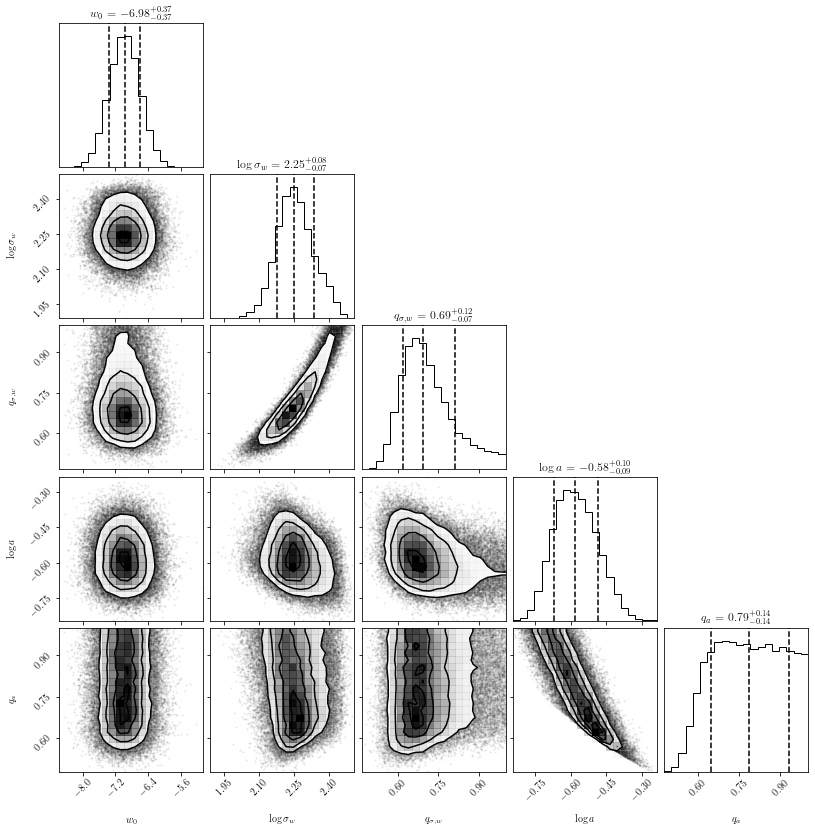

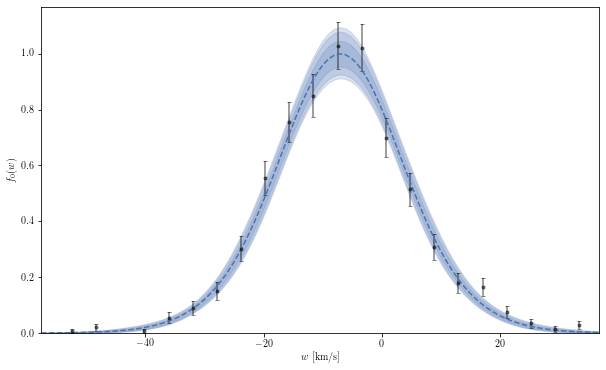

phi_max =  566.3188119672805
60000


100%|██████████| 60000/60000 [00:04<00:00, 12521.78it/s]


med and mad...
calculate pred...


100%|█████████▉| 999/1000 [00:04<00:00, 203.69it/s]


saving...
done pred_396.npy





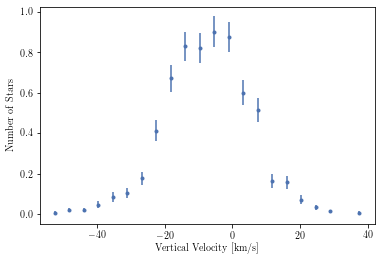

Running MCMC


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Running long mcmc


6it [00:00, 45.56it/s]
100%|██████████| 5000/5000 [00:00<00:00, 42217.79it/s]


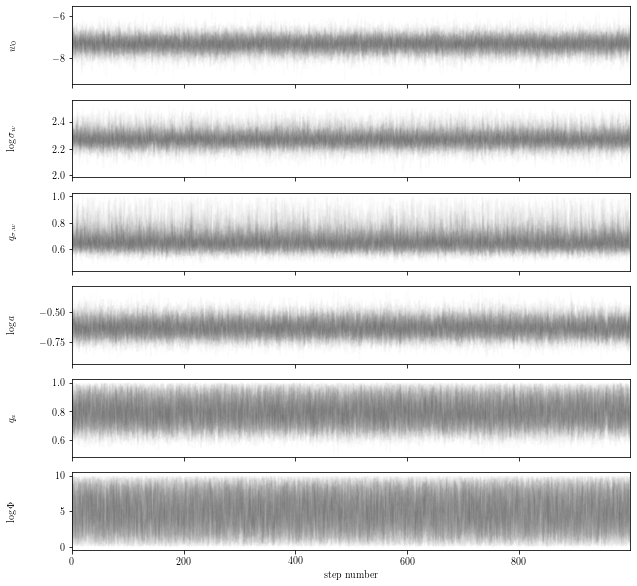

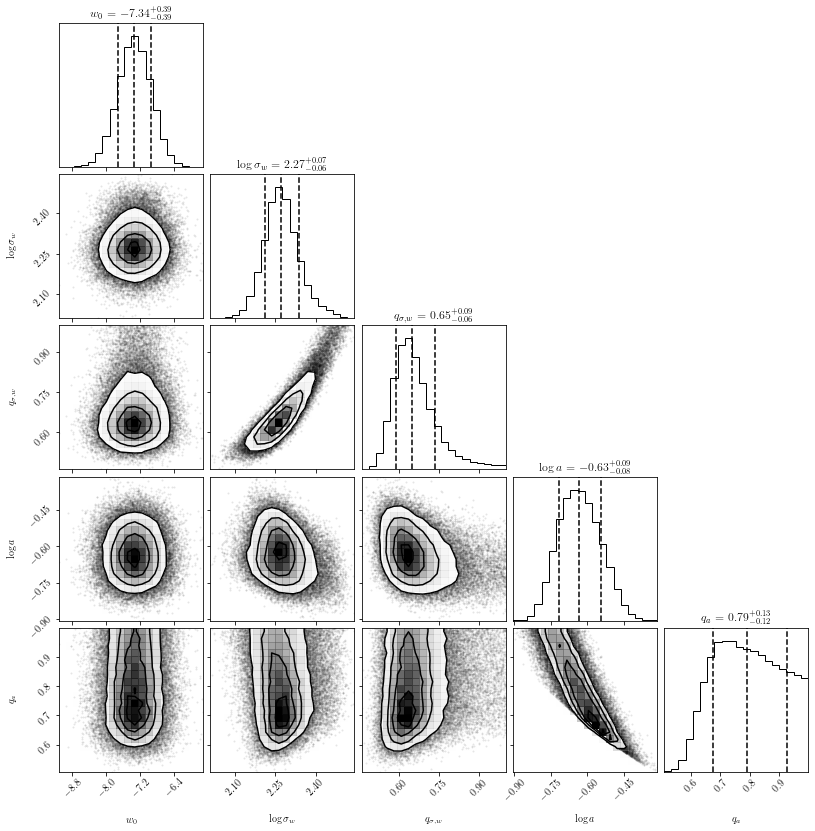

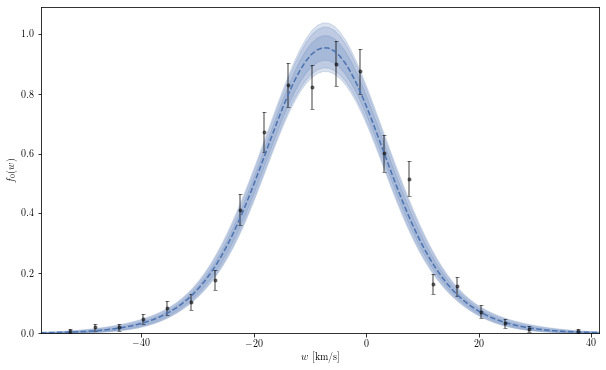

phi_max =  821.4634486757427
60000


100%|██████████| 60000/60000 [00:05<00:00, 11696.01it/s]


med and mad...
calculate pred...


100%|█████████▉| 999/1000 [00:05<00:00, 193.24it/s]


saving...
done pred_576.npy





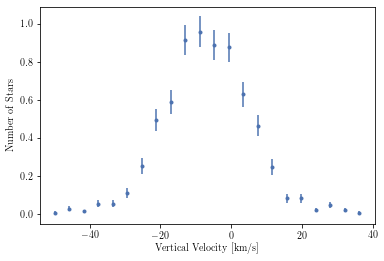

Running MCMC


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Running long mcmc


6it [00:00, 41.22it/s]
100%|██████████| 5000/5000 [00:00<00:00, 44344.75it/s]


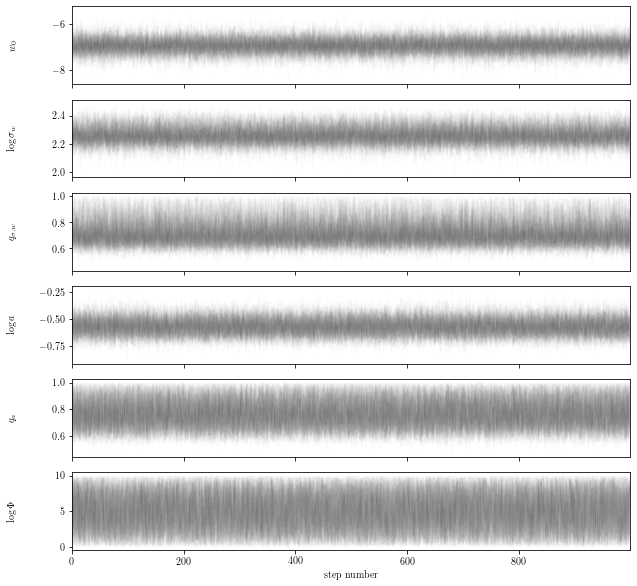

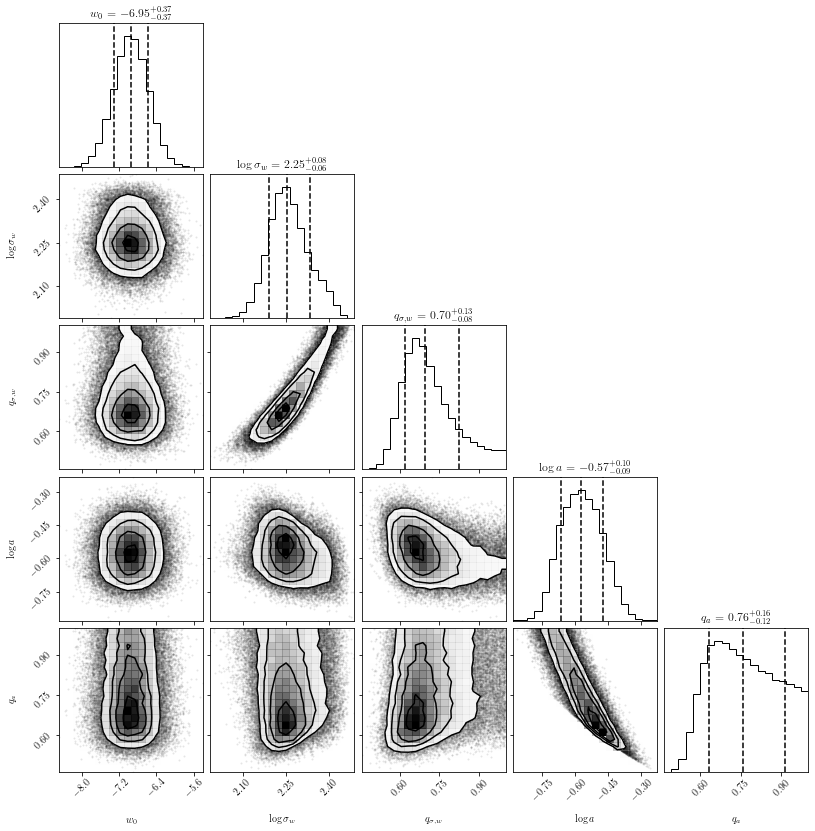

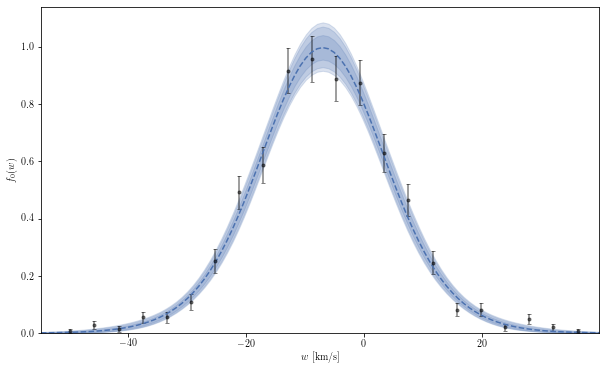

phi_max =  1069.8374739036599
60000


100%|██████████| 60000/60000 [00:04<00:00, 12250.03it/s]


med and mad...
calculate pred...


100%|█████████▉| 999/1000 [00:05<00:00, 199.43it/s]

saving...
done pred_747.npy





In [9]:
files = glob(join(zpath, "z*"))
files.sort()
for ind in range(1, len(files)):
    zdata, wdata = get_data(zpath, wpath, ind)    
    name_pred = files[ind].split("/")[-1].split(".")[0].replace("z", "pred") + ".npy"
    name_phi = files[ind].split("/")[-1].split(".")[0].replace("z", "phi") + ".npy"
    wmid, wnum, werr = wdata

    plt.errorbar(wmid, wnum, yerr=werr, fmt='.')
    plt.xlabel("Vertical Velocity [km/s]")
    plt.ylabel("Number of Stars")
    plt.show()

    psi, locs, scales, labels, labs = generate_init("kin")
    ndim = len(labs)
    nwalker = 10*ndim
    p0 = vel.generate_p0(nwalker, locs, scales)
    indexes = list(range(ndim))

    print("Running MCMC")
    for _ in tqdm(range(5)):
        chain = vel.mcmc(5000, p0, wdata, locs, scales, parallel=True, verbose=True)
        labs, locs_normal, scales_normal = get_initial_position_normal(labs, "kin", chain=chain[1000:], indexes=indexes)
        p0 = vel.generate_p0(nwalker, locs_normal, scales_normal, norm=True)
        chain = vel.mcmc(5000, p0, wdata, locs, scales, parallel=True, verbose=True)
        p0 = chain[-1]
    print("Running long mcmc")
    chain = vel.mcmc(100_000, p0, wdata, locs, scales, parallel=True, verbose=True)
    chain_thin = chain[::100]

    params = get_params(chain_thin, indexes, labs)
    plot_chain(params, labels, alpha=0.01)
    flat_samples = chain_thin.reshape(-1, ndim)
    plot_corner(flat_samples[:, :-1], labels[:-1])
    # plot
    plot_fit_w(wdata, flat_samples, n=5000, alpha=0.2, c="C0",path=None, dpi=100)
    phi_max = np.max(np.abs(zdata[0]))*1.5
    print("phi_max = ", phi_max)
    # potential space
    phis = np.linspace(0.0001, phi_max, 1000)
    N = len(flat_samples)
    print(N)
    log_zmod_phi = np.empty((N, len(phis)))
    for i in tqdm(range(N)):
        th = flat_samples[i]
        log_sigmaw = th[1]
        q_sigmaw = th[2]
        log_a = th[3]
        q_a = th[4]
        sigmaw1 = np.exp(log_sigmaw)
        sigmaw2 = sigmaw1 / q_sigmaw
        a1 = np.exp(log_a)
        a2 = a1 * q_a
        atot = a1 + a2
        zmod_phi_i = (a1*np.exp(-phis/sigmaw1**2)+a2*np.exp(-phis/sigmaw2**2))/atot
        log_zmod_phi[i] = np.log(zmod_phi_i)
    print("med and mad...")
    med = np.median(log_zmod_phi, axis=0)
    mad = mad_func(log_zmod_phi, axis=0)
    partition = 50
    pred = np.empty((len(phis), 2, partition))
    print("calculate pred...")
    for i, (log_zmod_phi_i, med_i, mad_i) in enumerate(zip(log_zmod_phi.T, med, tqdm(mad))):
        mask = np.abs(log_zmod_phi_i-med_i) < 6*mad_i
        log_zmod_phi_i = log_zmod_phi_i[mask]
        low = med_i-6*mad_i
        high = med_i+6*mad_i
        log_znum_edge = np.linspace(low, high, partition+1)
        dy = log_znum_edge[1]-log_znum_edge[0]
        log_znum_mod = (log_znum_edge[1:]+log_znum_edge[:-1])/2
        znum_weight, _ = np.histogram(log_zmod_phi_i, bins=log_znum_edge)
        total = znum_weight.sum()
        znum_weight = znum_weight/total
        pred_i = np.array([np.exp(log_znum_mod), znum_weight])
        pred[i] = pred_i
    print("saving...")
    np.save(join(zpath, 'PHI', name_pred), pred)
    np.save(join(zpath, 'PHI', name_phi), phis)
    print("done", name_pred)
    print("\n\n")
    # break